# Import Ntuple

In [2]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables + ['Ecms','B0_CMS_roeP_my_mask']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# 4S_offres Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

MC_4Soffres = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/4Soffres_quaxo_6.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4Soffres = uproot.concatenate([f'../../Samples/Data/e_channel/*4Soffres_quaxo_1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
df_data_4Soffres = pd.DataFrame(data_4Soffres)

In [15]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'sig_prob>0'

In [16]:
for df in [df_mc_4S, df_mc_4Soffres,df_data_4Soffres,]: #df_mc_4S,df_data_4S]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [17]:
df_mc_4Soffres.eval('roeMbc_cor = ( (10.58/2)**2 - (B0_CMS_roeP_my_mask*10.58/Ecms)**2 )**0.5', inplace=True)
df_mc_4Soffres['B0_roeMbc_my_mask'] = df_mc_4Soffres['roeMbc_cor']
df_mc_4S.eval('roeMbc_cor = B0_roeMbc_my_mask', inplace=True)

In [ ]:
# ag + BCS
df_mc_4S_ag = util.apply_mva_bcs(df_mc_4S, training_variables, ag_tight, 
                                  library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
df_mc_4Soffres_ag = util.apply_mva_bcs(df_mc_4Soffres, training_variables, ag_tight, 
                                  library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
df_data_4Soffres_ag = util.apply_mva_bcs(df_data_4Soffres, training_variables, ag_tight, 
                                  library='ag',version='ag-20241203_203215',model='NeuralNetTorch')

In [18]:
# lgb + BCS
df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_tight,library='lgbm')
df_mc_4Soffres_lgb = util.apply_mva_bcs(df_mc_4Soffres, training_variables, lgb_tight,library='lgbm')
df_data_4Soffres_lgb = util.apply_mva_bcs(df_data_4Soffres, training_variables, lgb_tight,library='lgbm')

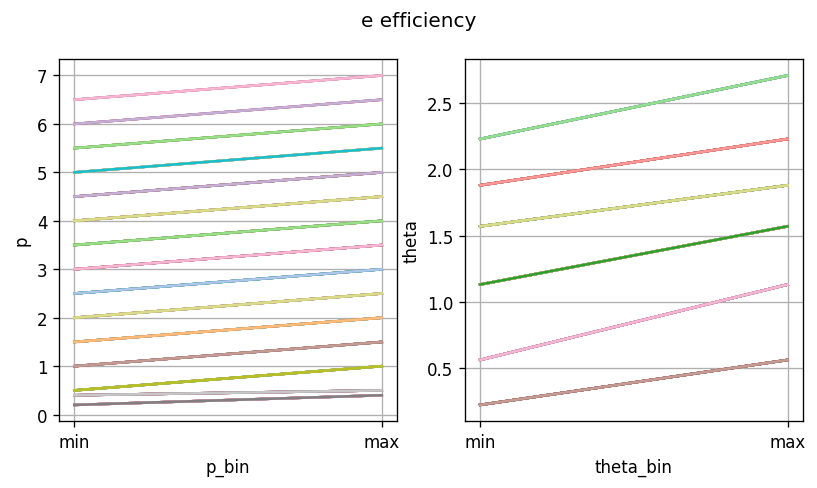

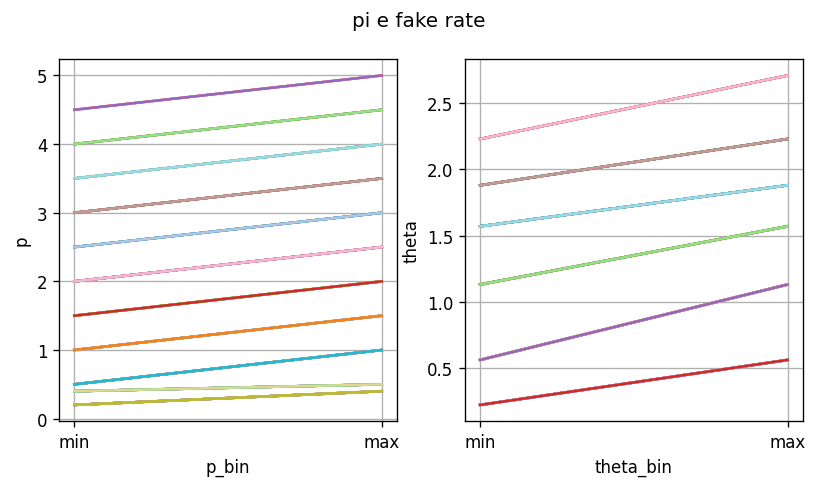

In [5]:
# PID corrections, get tables
pid = util.PID_corrections()
exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) \
and not (theta_min == 0.22 and theta_max == 2.71) \
and not (theta_min == 0.56 and theta_max == 2.23)"
e_eff, e_fake = pid.get_lepton_tables(lepton='e', var="pidChargedBDTScore_e",
                          thres=0.9, exclude_bins=exclude_e_bins_query)
K_eff, K_fake = pid.get_hadron_tables(new_table=False, hadron='K', var='kaonIDNN', thres=0.9)

Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 93.8%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 92.1%


/tmp/ipykernel_2125318/671596483.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 89.1%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 88.3%


/tmp/ipykernel_2125318/671596483.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


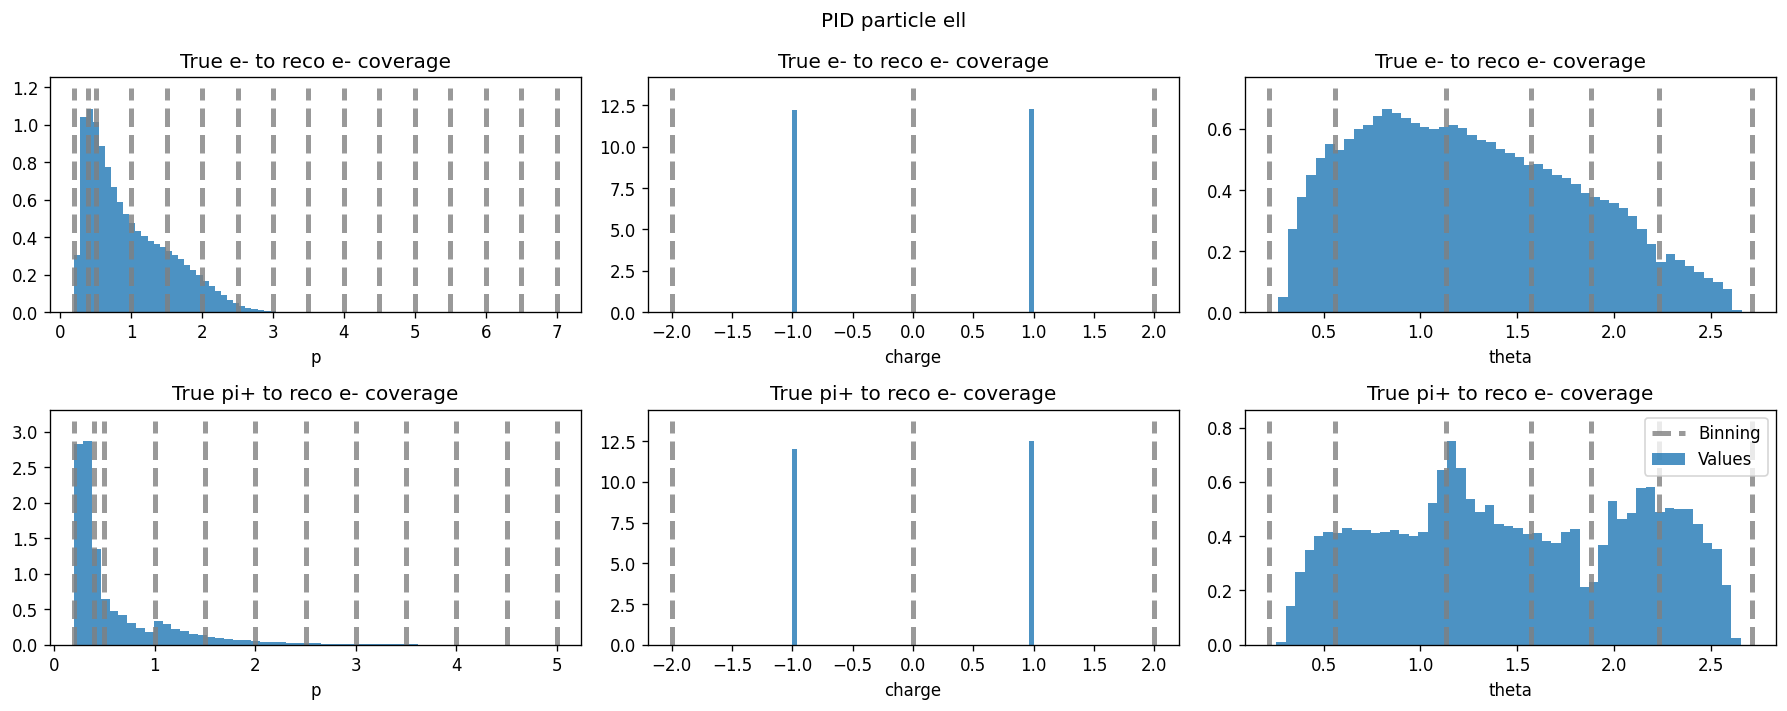

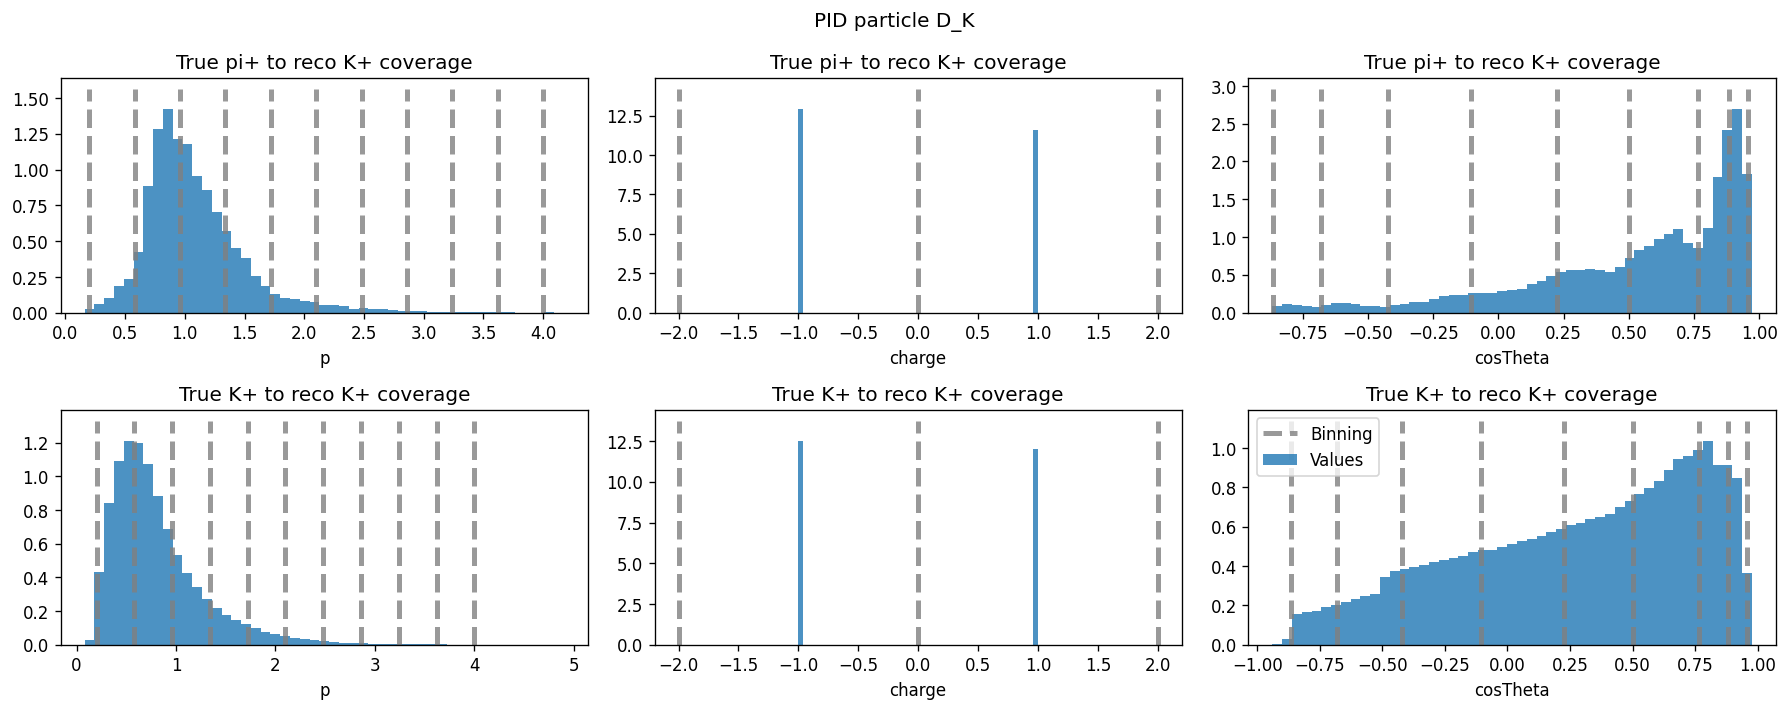

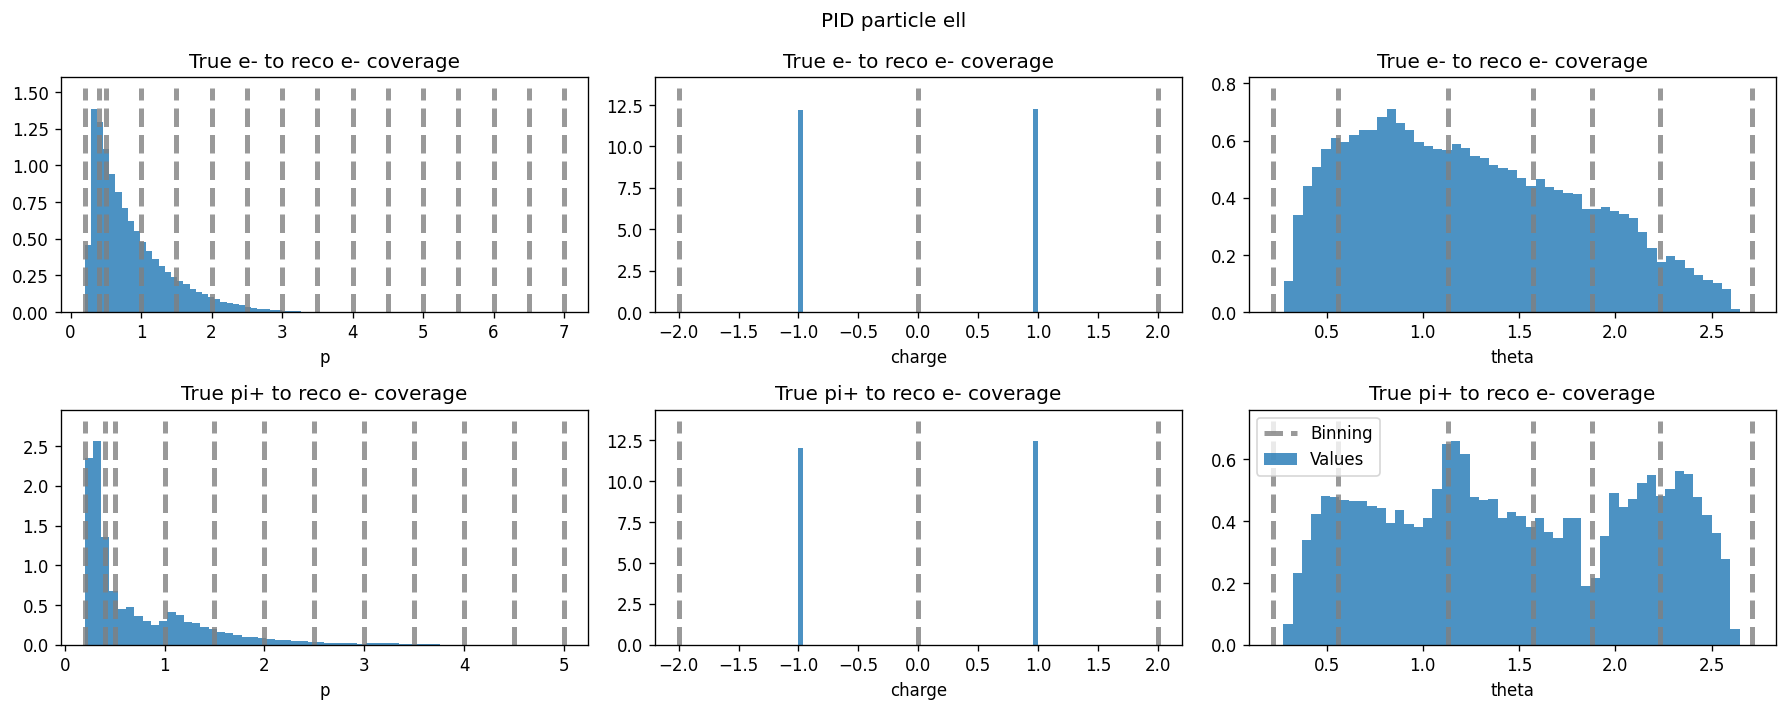

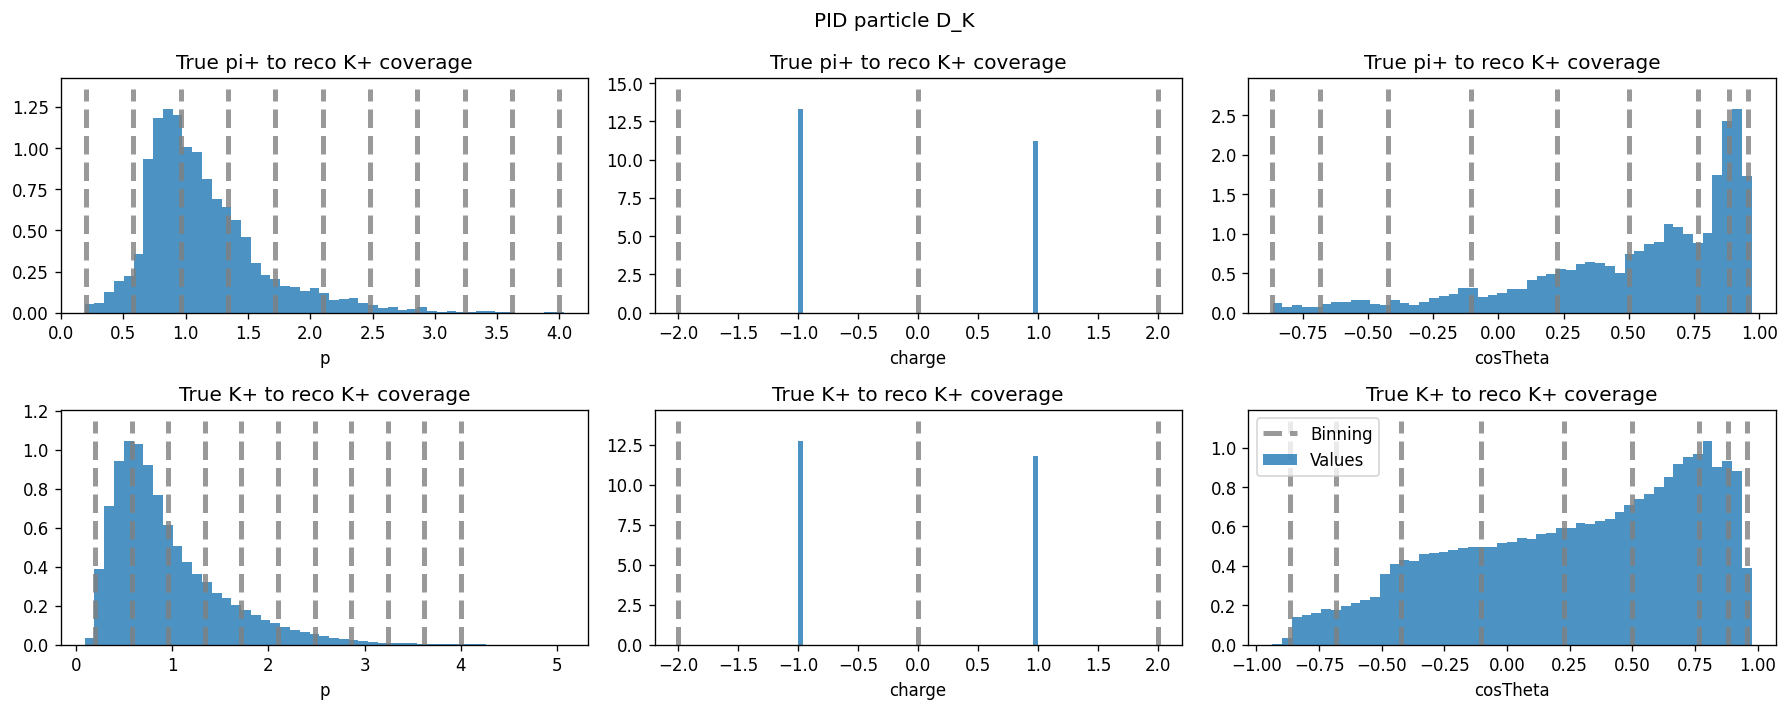

In [9]:
# Apply PID corrections
for df in [df_mc_4S_lgb, df_mc_4Soffres_lgb]:
    pid.apply_corrections(eff_table=e_eff, fake_table=e_fake, df=df, plots=True,
                          p='e', var='pidChargedBDTScore_e', thres=0.9)
    pid.apply_corrections(eff_table=K_eff, fake_table=K_fake, df=df, plots=True,
                          p='K', var='kaonIDNN', thres=0.9)
    df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)
    df = df.copy()

In [ ]:
columns_without_nan = df_data_4Soffres_ag.columns[~df_data_4Soffres_ag.isna().any()].tolist()

samples_control=util.get_dataframe_samples_new(df_mc_4Soffres_ag, 'e', template=False)
samples_sig = util.get_dataframe_samples_new(df_mc_4S_ag, 'e', template=False)
mpl=util.mpl(samples_control,df_data_4Soffres_ag)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_control.items():
    print(name, len(df))

In [19]:
columns_without_nan = df_data_4Soffres_lgb.columns[~df_data_4Soffres_lgb.isna().any()].tolist()

samples_control=util.get_dataframe_samples_new(df_mc_4Soffres_lgb, 'e', template=False)
samples_sig = util.get_dataframe_samples_new(df_mc_4S_lgb, 'e', template=False)
mpl=util.mpl(samples_control,df_data_4Soffres_lgb)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_control.items():
    print(name, len(df))

bkg_fakeD 482
bkg_TDFl 83
bkg_fakeTracks 14
bkg_continuum 819
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


# Check 4S vs. 4S_offres

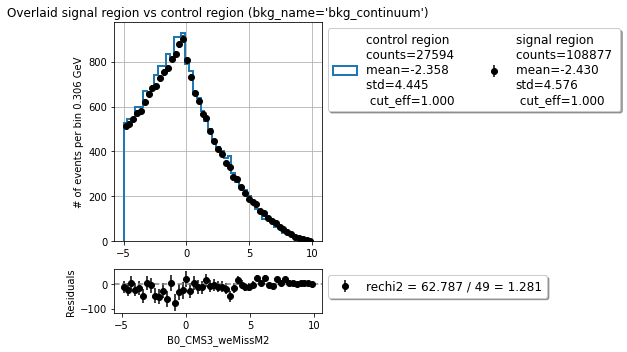

In [17]:
# compare control vs signal regions MC
b1 = np.linspace(-5,10,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

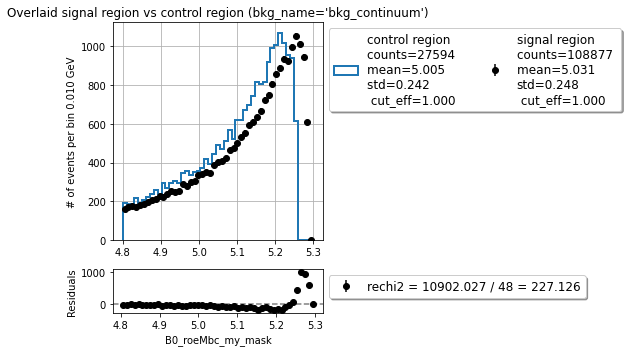

In [13]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_roeMbc_my_mask',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

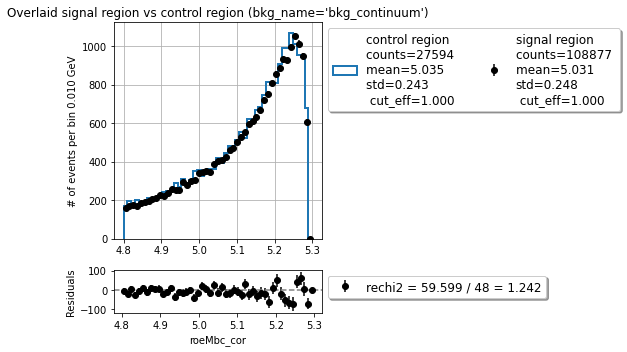

In [14]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='roeMbc_cor',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

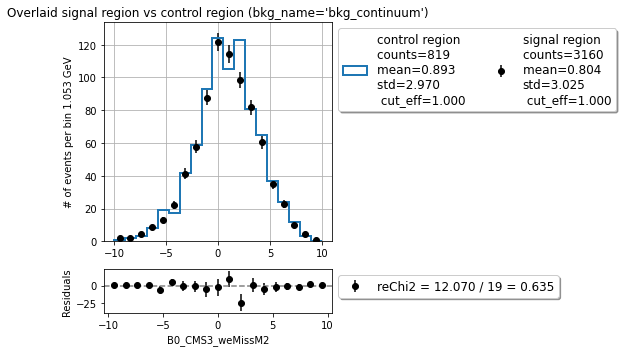

In [22]:
# compare control vs signal regions MC
b1 = np.linspace(-10,10,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

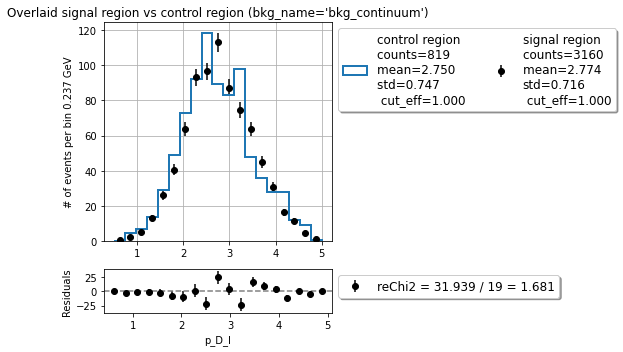

In [21]:
b2 = np.linspace(0.5,5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

# Check Data vs. MC

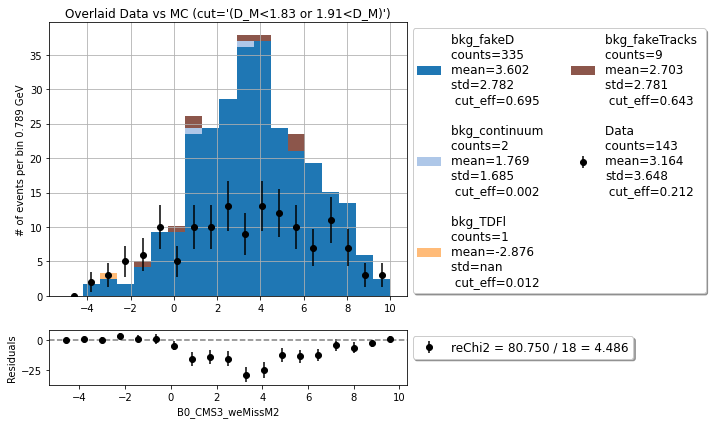

In [25]:
# BDT sig, D sidebands
b1 = np.linspace(-5,10,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or 1.91<D_M)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

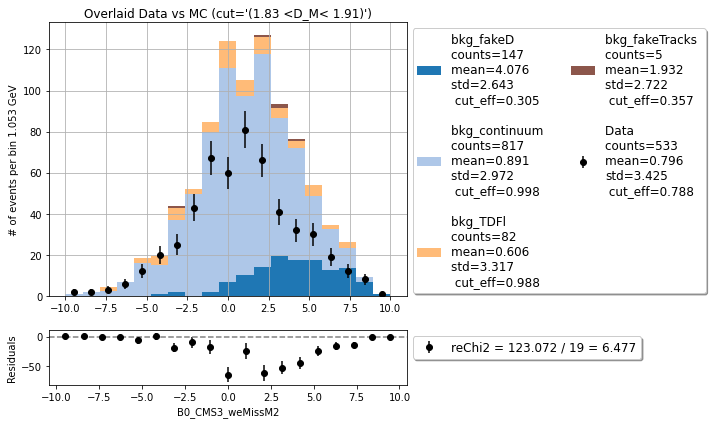

In [27]:
# BDT sig, D sig
b1 = np.linspace(-10,10,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

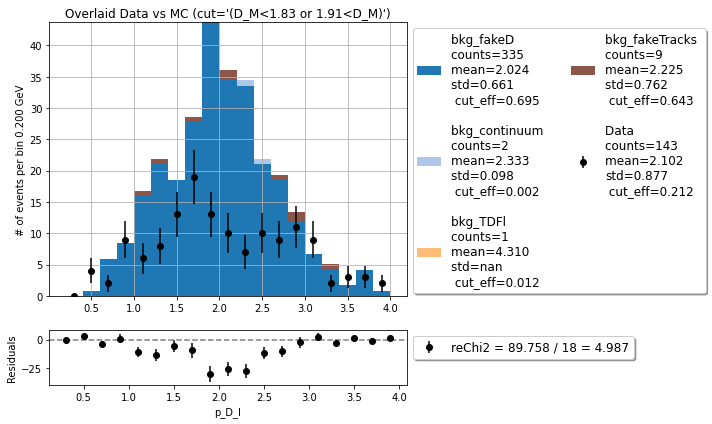

In [29]:
# BDT sig, D signal
b2 = np.linspace(0.2,4,20)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(10,6),
                          cut='(D_M<1.83 or 1.91<D_M)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

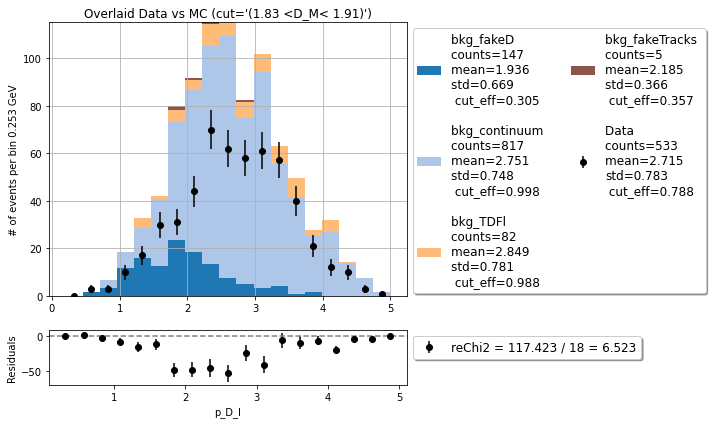

In [32]:
# BDT all, D signal
b2 = np.linspace(0.2,5,20)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

# Create data driven template for continuum
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

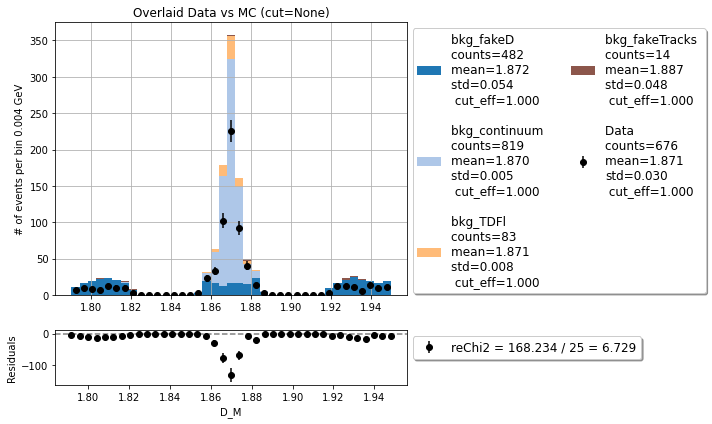

In [37]:
# BDT signal region
b1 = np.linspace(1.79,1.95,40)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      scale=[1,42/50],correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

### b. fit the FakeD with a polynomial

In [17]:
fitter = util.fit_iminuit(x_edges=b1, hist=data_hist_all, poly_only=False)

In [ ]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 8.4000e+00  1.8700e+00  5.0000e-02 -3.8050e+02  1.1337e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 65.24 (χ²/ndof = 1.4)      │              Nfcn = 418              │
│ EDM = 2.05e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   7.47    │   0.19    │            │            │    0    │         │       │
│ 1 │ x1   │  1.87038  │  0.00010  │            │            │    0    │         │       │
│ 2 │ x2   │  3.73e-3  │  0.11e-3  │            │            │    0    │         │       │
│ 3 │ x3   │   -480    │    60     │            │            │         │         │       │
│ 4 │ x4   │  1.57e3   │  0.11e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │          x0          x1          x2          x3          x4 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │      0.0357     -515e-9   10.593e-6        0.26       -0.79 │
│ x1 │     -515e-9    9.45e-09       -1e-9 -204.590e-6  388.641e-6 │
│ x2 │   10.593e-6       -1e-9    1.14e-08  112.253e-6 -332.788e-6 │
│ x3 │        0.26 -204.590e-6  112.253e-6    3.52e+03      -6.6e3 │
│ x4 │       -0.79  388.641e-6 -332.788e-6      -6.6e3    1.24e+04 │
└────┴─────────────────────────────────────────────────────────────┘

In [10]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 4.17510e+03  1.87000e+00  5.00000e-02  4.17514e+04 -3.80500e+02
  1.13300e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 55.92 (χ²/ndof = 1.2)      │              Nfcn = 395              │
│ EDM = 3.31e-06 (Goal: 0.0002)    │            time = 1.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  4.62e3   │  0.13e3   │            │            │    0    │         │       │
│ 1 │ x1   │  1.86957  │  0.00011  │            │            │    0    │         │       │
│ 2 │ x2   │  3.70e-3  │  0.12e-3  │            │            │    0    │         │       │
│ 3 │ x3   │  65.9e3   │   0.4e3   │            │            │         │         │       │
│ 4 │ x4   │  -0.14e3  │  0.12e3   │            │            │         │         │       │
│ 5 │ x5   │   0.5e3   │   0.4e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────────────────────────────┐
│    │            x0            x1            x2            x3            x4            x5 │
├────┼─────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │      1.66e+04   -447.387e-6   8.082984e-3      -0.022e6             0             0 │
│ x1 │   -447.387e-6      1.15e-08     -0.001e-6    820.839e-6    -16.855e-6    -47.083e-6 │
│ x2 │   8.082984e-3     -0.001e-6      1.37e-08 -14.991377e-3      2.523e-6      6.994e-6 │
│ x3 │      -0.022e6    820.839e-6 -14.991377e-3      1.65e+05            -0            -0 │
│ x4 │             0    -16.855e-6      2.523e-6            -0      1.44e+04      -0.047e6 │
│ x5 │             0    -47.083e-6      6.994e-6            -0      -0.047e6      1.51e+05 │
└────┴─────────────────────────────────────────────────────────────────────────────────────┘

In [18]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 1.068e+02  1.870e+00  3.000e-02  1.068e+03 -3.700e+00  1.780e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 67.2 (chi2/ndof = 1.4)     │              Nfcn = 518              │
│ EDM = 9.3e-06 (Goal: 0.0002)     │            time = 6.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    706    │    29     │            │            │    0    │         │       │
│ 1 │ x1   │  1.86999  │  0.00017  │            │            │    0    │         │       │
│ 2 │ x2   │  3.86e-3  │  0.17e-3  │            │            │    0    │         │       │
│ 3 │ x3   │    630    │    40     │            │            │         │         │       │
│ 4 │ x4   │    -7     │    13     │            │            │         │         │       │
│ 5 │ x5   │    20     │    40     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │       872 -5.36e-05   0.00131      -307     0.042      0.11 │
│ x1 │ -5.36e-05  2.96e-08 -8.95e-10  9.85e-05 -7.87e-06 -2.07e-05 │
│ x2 │   0.00131 -8.95e-10  2.87e-08  -0.00239  7.41e-07  1.95e-06 │
│ x3 │      -307  9.85e-05  -0.00239  1.75e+03   -0.0772    -0.202 │
│ x4 │     0.042 -7.87e-06  7.41e-07   -0.0772       158      -449 │
│ x5 │      0.11 -2.07e-05  1.95e-06    -0.202      -449  1.34e+03 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [19]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82: 126.259
Yields from 1.855 to 1.885: 118.831
Yields from 1.92 to 1.95: 111.402


In [20]:
a = len(samples_control['bkg_FakeD'].query('1.79<D_M<1.82')) * 42/50
b = len(samples_control['bkg_FakeD'].query('1.92<D_M<1.95')) * 42/50
print('truth',a,b, a/b)

truth 152.04 175.56 0.8660287081339713


### d. Plot and compare MC of the weighted sideband and signal region

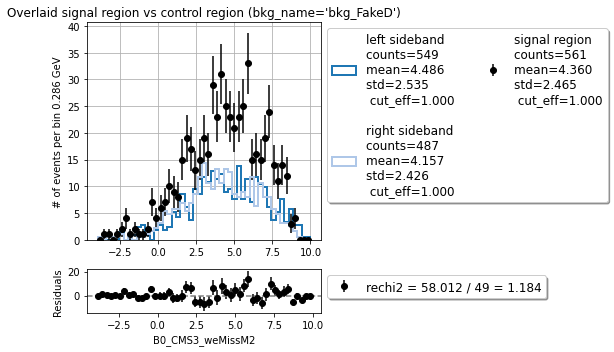

In [16]:
# BDT signal
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=False,
                        scale=scale,correction=False,mask=[])

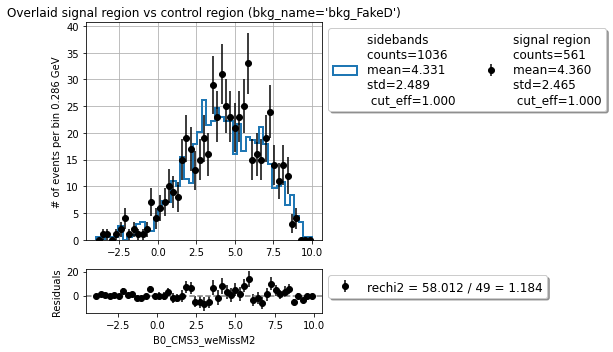

In [16]:
# BDT signal
b1 = np.linspace(-4,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[])

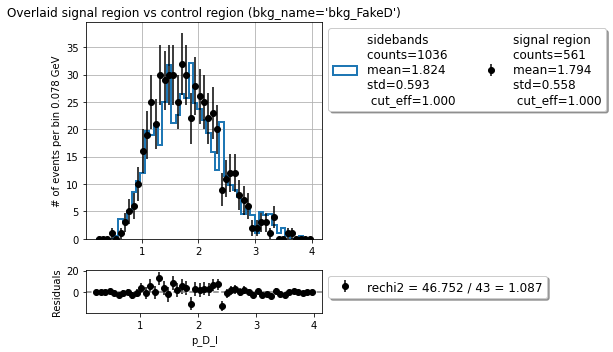

In [17]:
# BDT signal
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

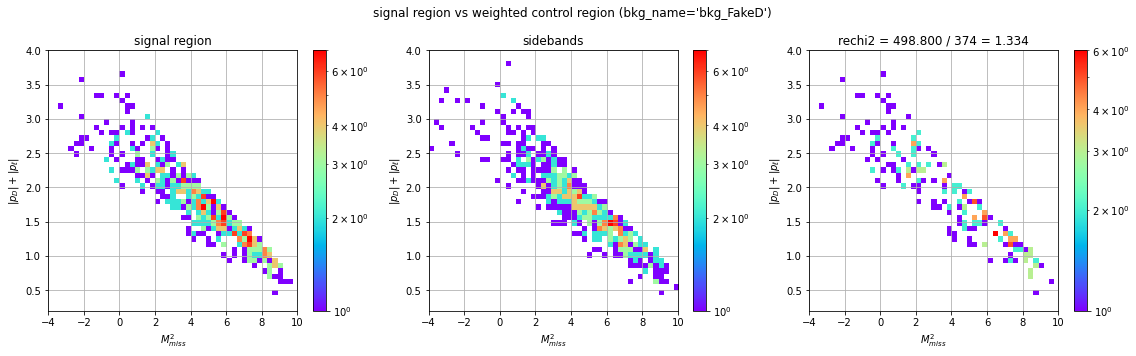

In [15]:
# BDT signal
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

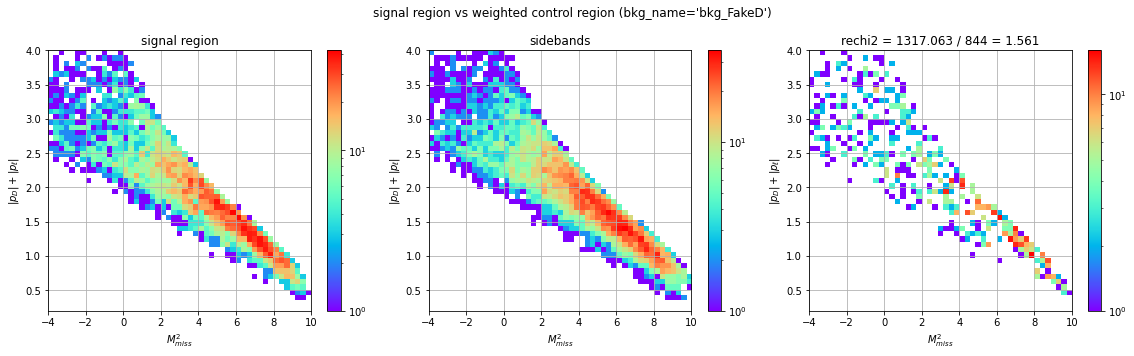

In [17]:
# BDT continuum
b1 = np.linspace(-4,10,50)
b2 = np.linspace(0.2,4,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD in the signal region

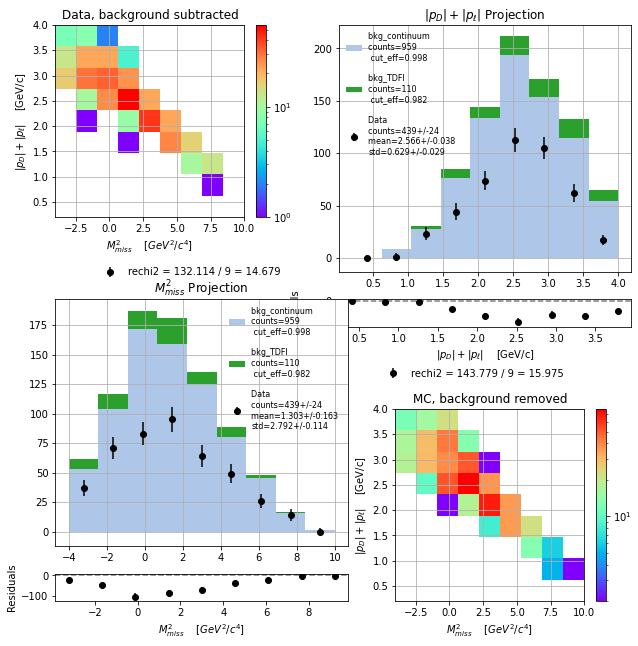

In [24]:
# BDT signal
b_mm2 = np.linspace(-4,10,10)
b_pDl = np.linspace(0.2,4,10)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'scale': scale,
          'correction': False,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

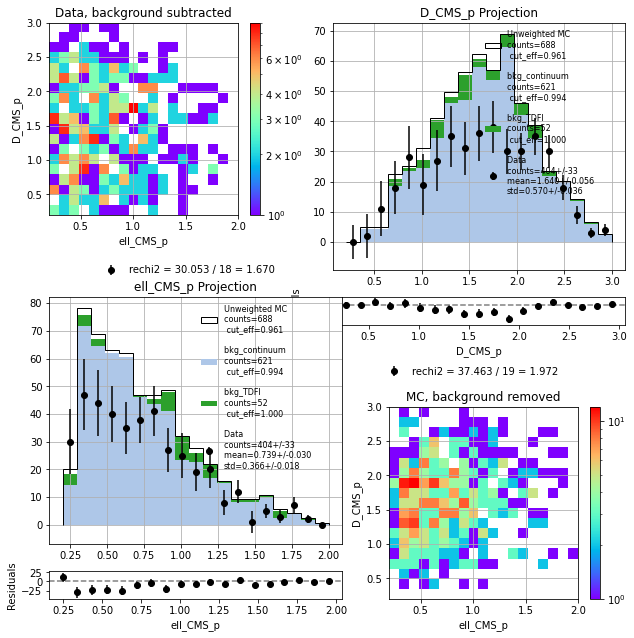

In [16]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2,20)
b_pDl = np.linspace(0.2,3,20)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

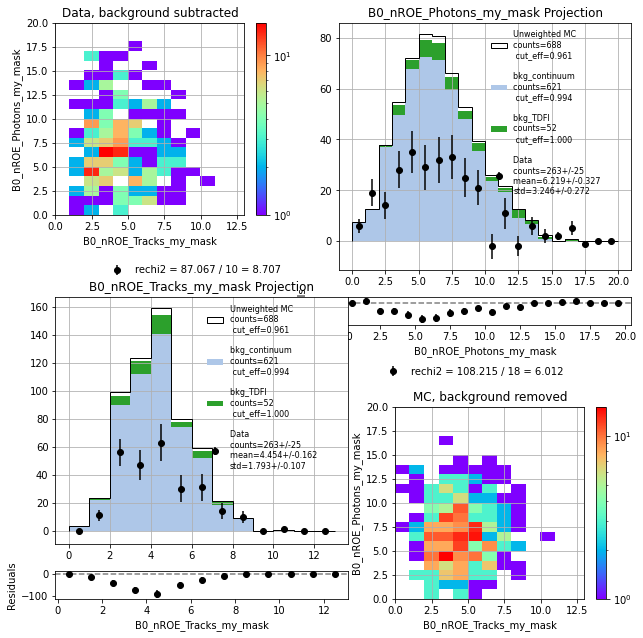

In [17]:
# BDT signal, nTracks; nPhotons                    
b_x = np.linspace(0,13,14)
b_y = np.linspace(0,20,21)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_nROE_Tracks_my_mask','B0_nROE_Photons_my_mask'],
          'bin_list': [b_x, b_y],
          'cut': '0<B0_CMS3_weMissM2<6',
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

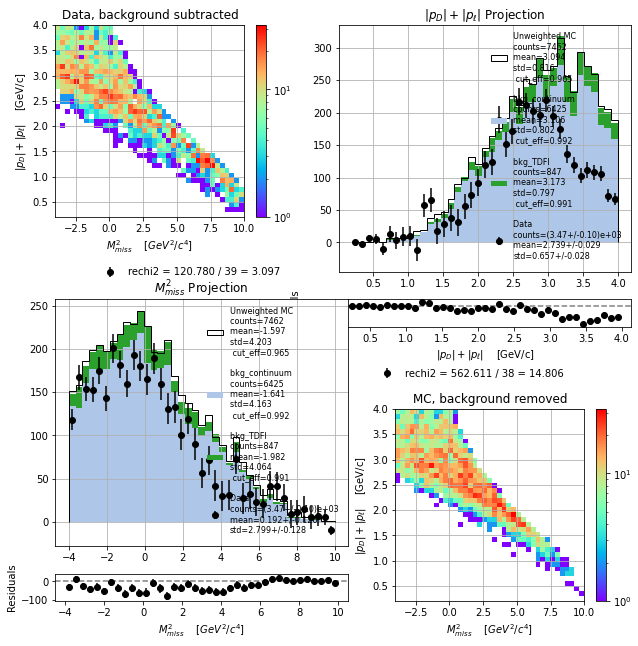

In [23]:
# BDT continuum
b_mm2 = np.linspace(-4,10,40)
b_pDl = np.linspace(0.2,4,40)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': True,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)